In [1]:
import awkward as ak
import numpy as np
import hist
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
DelphesSchema.mixins.update({
    "GenParticle": "Particle",
    "GenCandidate": "Particle",
    "ParticleFlowCandidate": "Particle",
    "DarkHadronCandidate": "Particle",
    "FatJet": "Jet",
    "GenFatJet": "Jet",
    "DarkHadronJet": "Jet",
})

In [2]:
samples = [
    {"name": "CMS", "model": "s-channel_mmed-1000_Nc-2_Nf-2_scale-35.1539_mq-10_mpi-20_mrho-20_pvector-0.75_spectrum-cms_rinv-0.3"},
    {"name": "Snowmass (CMS-like)", "model": "s-channel_mmed-1000_Nc-3_Nf-3_scale-33.3333_mq-33.73_mpi-20_mrho-83.666_pvector-0.5_spectrum-snowmass_cmslike_rinv-0.3"}
]

In [3]:
# load data and metadata
from svjHelper import svjHelper
for sample in samples:
    path = f'models/{sample["model"]}'
    sample["helper"] = svjHelper.build(f'{path}/config.py')
    metadict = sample["helper"].metadata()
    metadict["dataset"] = sample["name"]
    sample["events"] = NanoEventsFactory.from_root(
        file=f'{path}/events.root',
        treepath="Delphes",
        schemaclass=DelphesSchema,
        metadata=metadict,
    ).events()

In [4]:
# apply basic selections and compute derived quantities
for sample in samples:
    events = sample["events"]
    # require two jets
    mask = ak.num(events.FatJet)>=2
    events = events[mask]
    # transverse mass calculation
    events["Dijet"] = events.FatJet[:,0]+events.FatJet[:,1]
    def ET(vec):
        return np.sqrt(vec.px**2+vec.py**2+vec.mass**2)
    E1 = ET(events.Dijet)
    E2 = events.MissingET.MET
    MTsq = (E1+E2)**2-(events.Dijet.px+events.MissingET.px)**2-(events.Dijet.py+events.MissingET.py)
    events["MT"] = np.sqrt(MTsq, where=MTsq>=0)
    # store modified events array
    sample["events"] = events

In [5]:
# helper functions to fill histograms

def get_values(var,sample):
    return ak.flatten(sample["events"][var],axis=None)

def fill_hist(var,nbins,bmin,bmax,label,samples):
    hists = {}
    for sample in samples:
        h = (
            hist.Hist.new
            .Reg(nbins, bmin, bmax, label=label)
            .Double()
        )
        h.fill(get_values(var,sample),weight=0.5)
        hists[sample["name"]] = h
    return hists

In [6]:
# stylistic options

mpl.rcParams.update({
    "axes.labelsize" : 18,
    "legend.fontsize" : 16,
    "xtick.labelsize" : 14,
    "ytick.labelsize" : 14,
    "font.size" : 18,
    "legend.frameon": True,
})
# based on https://github.com/mpetroff/accessible-color-cycles
# red, blue, mauve, orange, purple, gray, 
colors = ["#e42536", "#5790fc", "#964a8b", "#f89c20", "#7a21dd", "#9c9ca1"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

In [7]:
# helper to make a plot

def make_plot(hname,hists):
    fig, ax = plt.subplots(figsize=(8,6))
    for l,h in hists.items():
        hep.histplot(h,density=True,ax=ax,label=l)
    ax.set_xlim(h.axes[0].edges[0],h.axes[0].edges[-1])
    ax.set_yscale("log")
    ax.set_ylabel("Arbitrary units")
    ax.legend(framealpha=0.5)
    plt.savefig('{}.pdf'.format(hname),bbox_inches='tight')

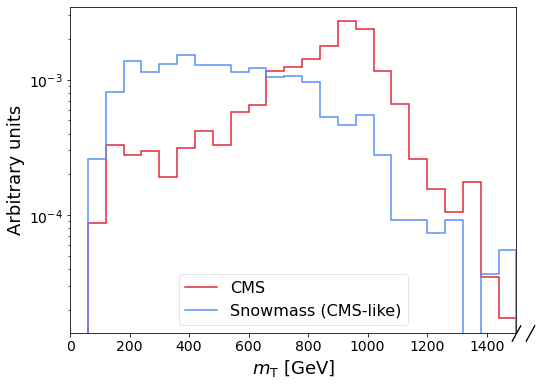

In [8]:
# plot transverse mass
hists_mt = fill_hist("MT",25,0,1500,r"$m_{\text{T}}$ [GeV]",samples)
make_plot("MT",hists_mt)